# IBMQ Demo

In this notebook we will go through the process of running quantum experiments on real quantum hardware, made available through IBMQ.


## Prerequisites

Uncomment the below line(s) and run the cell to install any library requirements.

Using IBMQ from qiskit results in a DeprecationWarning. I tried using the new package, called qiskit_ibm_provider, but the API is for me very slow. So using the deprecated module will have to do for now. After all, its just a warning...

You need to get your IBMQ API token from [here](https://quantum-computing.ibm.com/).

You need to get your Nasdaq Data Link API token from [here](https://data.nasdaq.com/account/profile).


In [1]:
# !python3 -m pip install qiskit_ibm_provider
# !python3 -m pip install qiskit
# !python3 -m pip install matplotlib
# !python3 -m pip install qiskit[finance]


## Module imports

In [2]:
from qiskit import IBMQ, Aer, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map
import matplotlib.pyplot as plt
import numpy as np
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo, LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit.providers.jobstatus import JobStatus
from datetime import datetime

import warnings
warnings.filterwarnings(
    'ignore',
    category=DeprecationWarning,
)


In [3]:
# Set up your IBMQ account here, replace below string with your token.
IMBQ_TOKEN = '<your-API-token>'
IBMQ.save_account(IMBQ_TOKEN, overwrite=True)
IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
# Define some helper functions

def print_backends(provider):
    """ Print all available backends for given provider. """
    for backend in provider.backends():
        print('\n' + ' '.join([f'{k}: {v}' for k, v in backend.status().to_dict().items()]))

def least_busy_backend(provider, n_qubits):
    """ Find the least busy non-simulator backend, with enough qubits. """
    filter_ = (
        lambda x: x.configuration().n_qubits >= (n_qubits + 1) and not
        x.configuration().simulator and
        x.status().operational == True
    )
    return least_busy(provider.backends(filters=filter_))
        

In [5]:
# Here you can run print_backends to see all available backends for the
# provider. You can then also find the least_busy if specific backend
# is not of interest.

provider = IBMQ.get_provider(
    hub='ibm-q',
    group='open',
    project='main',
)

# Define how many qubits you need, this is used to find least busy
# backend with at least enough qubits for the algorithm to run.
n_qubits = 5

print_backends(provider)
backend = least_busy_backend(provider, n_qubits)
print(f'\nThe least busy backend on IBMQ is: {backend}')



backend_name: ibmq_qasm_simulator backend_version: 0.1.547 operational: True pending_jobs: 4 status_msg: active

backend_name: ibmq_lima backend_version: 1.0.45 operational: True pending_jobs: 39 status_msg: active

backend_name: ibmq_belem backend_version: 1.2.5 operational: True pending_jobs: 29 status_msg: active

backend_name: ibmq_quito backend_version: 1.1.38 operational: True pending_jobs: 70 status_msg: active

backend_name: simulator_statevector backend_version: 0.1.547 operational: True pending_jobs: 4 status_msg: active

backend_name: simulator_mps backend_version: 0.1.547 operational: True pending_jobs: 4 status_msg: active

backend_name: simulator_extended_stabilizer backend_version: 0.1.547 operational: True pending_jobs: 4 status_msg: active

backend_name: simulator_stabilizer backend_version: 0.1.547 operational: True pending_jobs: 4 status_msg: active

backend_name: ibmq_manila backend_version: 1.1.3 operational: True pending_jobs: 65 status_msg: active

backend_name:

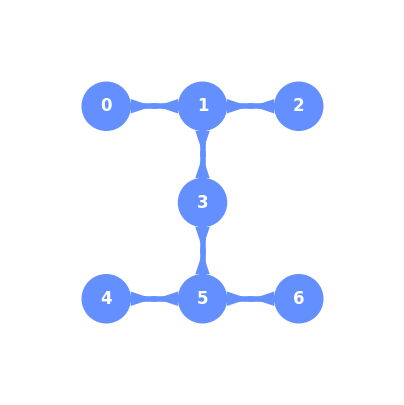

In [6]:
# If you want to use another backend other than the least_busy
# which was found above, uncomment the below line and insert
# your preferred backend.

# backend = '<your-backend>'
backend = provider.get_backend(str(backend))
display(plot_gate_map(backend, plot_directed=True))


## Solving portfolio optimization

Now we are going to define an instance of the portfolio optimization problem, and solve it one a real quantum backend using the VQE algorithm.


In [7]:
# Setup connection to Nasdaq Data Link, insert your token below.
NASDAQ_TOKEN = '<your-API-token>'
stocks = ['GOOG', 'MSFT', 'AAPL', 'AMZN', 'NFLX']

try:
    wiki = WikipediaDataProvider(
        token=NASDAQ_TOKEN,
        tickers=stocks,
        start=datetime(2016, 1, 1),
        end=datetime(2017, 1, 1),
    )
    wiki.run()
except QiskitFinanceError as err:
    print('Error retrieving the data, ', err)
    

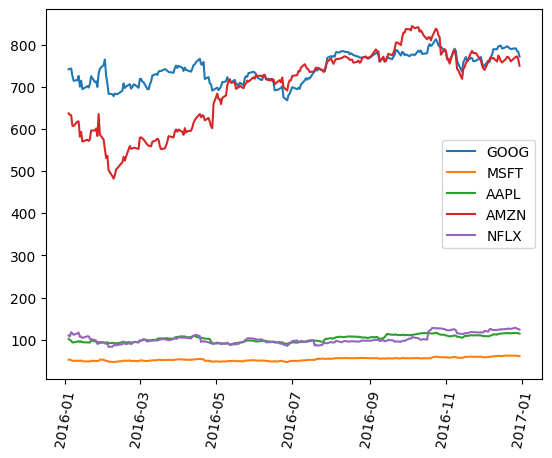

In [8]:
# Could be interesting to see and take a look at the stock price
# evolution to verify that the correct tickers have been fetched.

if wiki._data:
    for i, s in enumerate(stocks):
        plt.plot(wiki._data[i], label=s)
    plt.legend()
    plt.xticks(rotation=80)
    plt.show()
    

## Portfolio optimization

We aim to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$
\begin{split}\begin{aligned} \min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\ \text{subject to: } 1^T x = B \end{aligned}\end{split}
$$

where $x\in\{0, 1\}^n$ denotes the vector of binary decision variables, $\mu\in\mathbb{R}^n$ defines the expected returns for the assets, $\Sigma\in\mathbb{R}^{n\times n}$ specifies the covariances between the assets, $q>0$ controls the risk appetite of the decision marker, and $B$ denotes the budget, i.e., the number of assets to be selected out of $n$.


In [9]:
num_assets = len(stocks)
assert num_assets == n_qubits


seed = 123 # any number, to maintain reproducability of experiments

q = 0.5
B = num_assets // 2
P = num_assets

mu = wiki.get_period_return_mean_vector()
sigma = wiki.get_period_return_covariance_matrix()

problem = PortfolioOptimization(
    expected_returns=mu,
    covariances=sigma,
    risk_factor=q,
    budget=B
)

quadratic_program = problem.to_quadratic_program()
display(quadratic_program)


<QuadraticProgram: minimize 7.851184752568564e-05*x_0^2 + 0.000125377365118773..., 5 variables, 1 constraints, 'Portfolio optimization'>

## Solving the combinatorial optimization classically...


In [10]:
exact = NumPyMinimumEigensolver()
exact_solver = MinimumEigenOptimizer(exact)

classical_result = exact_solver.solve(quadratic_program)
display(classical_result.x)


array([0., 1., 0., 1., 0.])

## Solve using VQE and COBYLA on backend


In [ ]:
# First we have to convert the problem to an unconstrained problem.

l2p = LinearEqualityToPenalty(penalty=P)
quadratic_program = l2p.convert(quadratic_program)

optimizer = COBYLA(maxiter=1)

ansatz = RealAmplitudes(num_assets, reps=1)

vqe = VQE(
    optimizer=optimizer,
    ansatz=ansatz,
    quantum_instance=backend,
)

# https://quantumcomputing.stackexchange.com/questions/21637/how-can-i-run-a-vqe-on-one-of-ibmqs-quantum-computers
optimizer_alg = MinimumEigenOptimizer(vqe)
result = optimizer_alg.solve(quadratic_program)


In [ ]:
print(result.x)

assert (classical_result.x == result.x).all()


Did we got the same optimal portfolio when running on a real quantum backend? Yea? Cool.